In [1]:
%matplotlib widget

from experiments import Experiment, _DefaultFloatLogSlider, _DefaultIntSlider

from translocation_models import TranslocationModel, \
    SC2R, SC2R2Loops, DefectiveSC2R, \
    DiscSpiral, DefectiveDiscSpiral

from ipywidgets import Widget, FloatLogSlider, IntSlider, \
    HBox, VBox, HTML, Output, Layout
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt


In [2]:
class SC2RDiscSpiralComparison(Experiment):
    def __init__(self):
        self._sc2r = SC2R()
        self._disc_spiral = DiscSpiral()
        super().__init__()

    def _construct_free_parameters(self) -> dict[str, Widget]:
        return {
            'atp_adp_ratio': _DefaultFloatLogSlider(
                value=1e2, min=0, max=4, readout_format='.1e',
                description="[ATP]/[ADP]:"),
            'equilibrium_atp_adp_ratio': _DefaultFloatLogSlider(
                value=1e-5, min=-7, max=-3, readout_format='.1e',
                description="([ATP]/[ADP])|eq.:"),
            'K_d_atp': _DefaultFloatLogSlider(
                value=0.1, description="K_d^ATP:"),
            'K_d_adp': _DefaultFloatLogSlider(description="K_d^ADP:"),
            'k_DT': _DefaultFloatLogSlider(description="k_DT:"),
            'k_h': _DefaultFloatLogSlider(description="k_h:"),
            'k_s': _DefaultFloatLogSlider(value=0.1, description="k_s:"),
            'k_up': _DefaultFloatLogSlider(description="k_↑:"),
            'n_protomers': _DefaultIntSlider(description="n_protomers:"),
            'k_extended_to_flat_up': _DefaultFloatLogSlider(description="k_⮫:"),
            'k_flat_to_extended_down': _DefaultFloatLogSlider(description="k_⮯:"),
            'k_flat_to_extended_up': _DefaultFloatLogSlider(description="k_⮭:"),
        }
    
    def _construct_constrained_parameters(self) -> dict[str, Widget]:
        return {
            'k_TD': HTML(description="k_TD:"),
            'k_down': HTML(description="k_↓:"),
            'k_h_bar': HTML(description="ꝁ_h:"),
            'k_flat_to_extended_down_bar': HTML(description="ꝁ_⮯:"),
            'k_extended_to_flat_down': HTML(description="k_⮩:"),
        }
    
    def _construct_gui(self) -> Widget:
        gui_plot = Output()
        gui_parameters = VBox([
            HTML(value=
                 "<h1>SC/2R and Disc-Spiral ATP consumption rate comparison</h1>"),

            HTML(value="<b>General Physical Parameters</b>"),
            HBox([self._free_parameters['atp_adp_ratio'],
                HTML(value="ATP/ADP concentration ratio")]),
            HBox([self._free_parameters['equilibrium_atp_adp_ratio'], 
                HTML(value="Equilibrium ATP/ADP concentration ratio")]),
            HBox([self._free_parameters['K_d_atp'],
                HTML(value="Protomer-ATP dissociation constant")]),
            HBox([self._free_parameters['K_d_adp'],
                HTML(value="Protomer-ADP dissociation constant")]),
            HBox([self._free_parameters['k_DT'],
                HTML(value="Effective ADP->ATP exchange rate")]),
            HBox([self._constrained_parameters['k_TD'],
                HTML(value="Effective ATP->ADP exchange rate "\
                    "(constrained by Protomer-ATP/ADP exchange model)")]),
            HBox([self._free_parameters['k_h'],
                HTML(value="ATP Hydrolysis rate")]),
            HBox([self._free_parameters['k_s'],
                HTML(value="ATP Synthesis rate")]),

            HTML(value="<b>SC2R Model Physical Parameters</b>"),
            HBox([self._free_parameters['k_up'],
                HTML(value="Translocation up rate")]),
            HBox([self._constrained_parameters['k_down'],
                HTML(value="Translocation down rate "\
                    "(constrained by detailed balance)")]),

            HTML(value="<b>Disc-Spiral Model Physical Parameters</b>"),
            HBox([self._free_parameters['n_protomers'],
                HTML(value="Number of protomers")]),
            HBox([self._constrained_parameters['k_h_bar'],
                HTML(value="Effective ATP hydrolysis rate")]),
            HBox([self._free_parameters['k_extended_to_flat_up'],
                HTML(value="Spiral->disc up translocation rate")]),
            HBox([self._free_parameters['k_flat_to_extended_down'],
                HTML(value="Disc->spiral down translocation rate")]),
            HBox([self._constrained_parameters['k_flat_to_extended_down_bar'],
                HTML(value="Effective disc->spiral down translocation rate")]),
            HBox([self._free_parameters['k_flat_to_extended_up'],
                HTML(value="Disc->spiral up translocation rate")]),
            HBox([self._constrained_parameters['k_extended_to_flat_down'],
                HTML(value="Spiral->disc down rate "\
                        "(constrained by detailed balance)")]),
        ])

        gui = HBox([gui_plot, gui_parameters], 
                   layout=Layout(align_items='center'))
        
        return gui
    
    def _run(self) -> None:
        # Update GUI<->Models
        models = [self._sc2r, self._disc_spiral]
        self._update_models_free_parameters(models, self._free_parameters)
        self._update_gui_constrained_parameters(models, 
                                                self._constrained_parameters)
        
        for model in models:
            model.normalize_average_velocity(inplace=True)

        n_steps = 100
        n_simulations = 3
        sc2r_trajectories = self._sc2r.gillespie(
            n_steps=n_steps, 
            n_simulations=n_simulations,
            cumulative_sums='position')
        # TODO debug this shit
        # When analytical, first value is NaN but not empirical, see why
        sc2r_analytical_position_stats = self._sc2r.analytical_attribute_stats(
            'position', sc2r_trajectories[0]['timestamp'])
        sc2r_empirical_position_stats = self._sc2r.empirical_attribute_stats(
            'position', n_steps=n_steps)
        disc_spiral_trajectories = self._disc_spiral.gillespie(
            n_steps=n_steps, 
            n_simulations=n_simulations,
            cumulative_sums='position')
        disc_spiral_analytical_position_stats = \
            self._disc_spiral.analytical_attribute_stats(
                'position', disc_spiral_trajectories[0]['timestamp'])
        disc_spiral_empirical_position_stats = \
            self._disc_spiral.empirical_attribute_stats(
                'position', n_steps=n_steps)
        # We cut all data that exceed the minmax empirical stats timestamp
        # because empirical stats are the limiting factor
        max_timestamp = min(
            sc2r_empirical_position_stats['timestamp'].iat[-1],
            disc_spiral_empirical_position_stats['timestamp'].iat[-1])
        for trajectory in sc2r_trajectories + disc_spiral_trajectories:
            trajectory.drop(
                trajectory[trajectory['timestamp'] > max_timestamp].index,
                inplace=True)
        for empirical_stats in [
            sc2r_empirical_position_stats,
            disc_spiral_empirical_position_stats]:
            empirical_stats.drop(
                empirical_stats[
                    empirical_stats['timestamp'] > max_timestamp].index,
                inplace=True)
        for analytical_stats in [
            sc2r_analytical_position_stats,
            disc_spiral_analytical_position_stats]:
            analytical_stats.drop(
                analytical_stats[
                    analytical_stats['timestamp'] > max_timestamp].index,
                inplace=True)
        
        gui_plot = self._gui.children[0]
        with gui_plot:
            gui_plot.clear_output(wait=True)
            plt.close('SC2RDiscSpiralComparison')
            fig = plt.figure('SC2RDiscSpiralComparison')
            ax = fig.add_subplot(111)

            ax.fill_between(
                sc2r_analytical_position_stats['timestamp'],
                sc2r_analytical_position_stats['mean'] - \
                    sc2r_analytical_position_stats['std'],
                sc2r_analytical_position_stats['mean'] + \
                    sc2r_analytical_position_stats['std'],
                color='#DDAA33', alpha=0.2)
            ax.fill_between(
                disc_spiral_analytical_position_stats['timestamp'],
                disc_spiral_analytical_position_stats['mean'] - \
                    disc_spiral_analytical_position_stats['std'],
                disc_spiral_analytical_position_stats['mean'] + \
                    disc_spiral_analytical_position_stats['std'],
                color='#004488', alpha=0.2)
            plt.show()
        
            
        


In [3]:
experiment = SC2RDiscSpiralComparison()

No such comm: 1f2aac7d9d824e9d9a7dce5bc2a16bc1
No such comm: 1f2aac7d9d824e9d9a7dce5bc2a16bc1
No such comm: 1f2aac7d9d824e9d9a7dce5bc2a16bc1
No such comm: 1f2aac7d9d824e9d9a7dce5bc2a16bc1
No such comm: 1f2aac7d9d824e9d9a7dce5bc2a16bc1
No such comm: 1f2aac7d9d824e9d9a7dce5bc2a16bc1
No such comm: 1f2aac7d9d824e9d9a7dce5bc2a16bc1
No such comm: 1f2aac7d9d824e9d9a7dce5bc2a16bc1
No such comm: 1f2aac7d9d824e9d9a7dce5bc2a16bc1
No such comm: 1f2aac7d9d824e9d9a7dce5bc2a16bc1
No such comm: 1f2aac7d9d824e9d9a7dce5bc2a16bc1
No such comm: 1f2aac7d9d824e9d9a7dce5bc2a16bc1
No such comm: 1f2aac7d9d824e9d9a7dce5bc2a16bc1
No such comm: 1f2aac7d9d824e9d9a7dce5bc2a16bc1
No such comm: 1f2aac7d9d824e9d9a7dce5bc2a16bc1
No such comm: 1f2aac7d9d824e9d9a7dce5bc2a16bc1
No such comm: 1f2aac7d9d824e9d9a7dce5bc2a16bc1
No such comm: 1f2aac7d9d824e9d9a7dce5bc2a16bc1
No such comm: 1f2aac7d9d824e9d9a7dce5bc2a16bc1
No such comm: 1f2aac7d9d824e9d9a7dce5bc2a16bc1


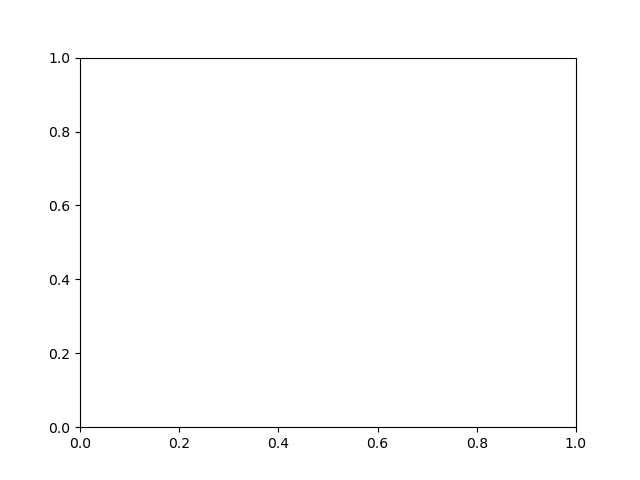

In [12]:
import pandas as pd
data_frame = pd.DataFrame({'a': [1, 2, 3]})

In [13]:
from experiments import VelocityVSATPADPRatio

VelocityVSATPADPRatio()

In [4]:
from scipy.stats import norm
import pandas as pd

data_frame = pd.DataFrame({
    'timestamp': np.linspace(0, 100, 100),
    'mean': np.linspace(0, 100, 100),
    'std': np.linspace(0, 100, 100)
})
intervals = norm.interval(0.95, loc=data_frame['mean'], scale=data_frame['std'])
print(intervals)
data_frame[['lower', 'upper']] = pd.DataFrame(intervals).T
print(data_frame)

(array([         nan,  -0.96966059,  -1.93932118,  -2.90898177,
        -3.87864236,  -4.84830295,  -5.81796354,  -6.78762413,
        -7.75728472,  -8.72694531,  -9.6966059 , -10.66626649,
       -11.63592709, -12.60558768, -13.57524827, -14.54490886,
       -15.51456945, -16.48423004, -17.45389063, -18.42355122,
       -19.39321181, -20.3628724 , -21.33253299, -22.30219358,
       -23.27185417, -24.24151476, -25.21117535, -26.18083594,
       -27.15049653, -28.12015712, -29.08981771, -30.0594783 ,
       -31.02913889, -31.99879948, -32.96846008, -33.93812067,
       -34.90778126, -35.87744185, -36.84710244, -37.81676303,
       -38.78642362, -39.75608421, -40.7257448 , -41.69540539,
       -42.66506598, -43.63472657, -44.60438716, -45.57404775,
       -46.54370834, -47.51336893, -48.48302952, -49.45269011,
       -50.4223507 , -51.39201129, -52.36167188, -53.33133247,
       -54.30099306, -55.27065366, -56.24031425, -57.20997484,
       -58.17963543, -59.14929602, -60.11895661, -61.0

/home/antoine/workspace/Projet-de-Master/.conda/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/antoine/workspace/Projet-de-Master/.conda/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
